In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import fetch_california_housing


# Decision Trees


A thought experiment: When you wake up and decide to attend class there are many factors in your decision.

1. The grade you want to get
2. Did you get a good night's sleep
3. Do you have a lot of other work to do
4. Do you think the class is important
5. Are you feeling sick
   ...

<br> 
Each of these affects the outcome of if you show up to class or not ... You can try to how much each of these features affects decision making


- Let's assume your decision is highly based on the weather

![](figs/Decision_Tree_1.png)


![](figs/Decision_Tree_Terminology.png)

- Nodes: split for a value of a particular attribute
- Edges: results of a particular decision


- Root: a node that performs the first split
- Leaves: the terminal output of each split


**How do we choose how to split the data?**


- We want to choose the splits that maximize the amount of information gained on the split


**Entropy**: If a sample is all of one class, entropy = 0, if it is evenly divided entropy = 1.


We need to compute two entropy for an attribute

1. Entropy for a single class
   $$E(T) = \sum_{i=1}^c -p_i\log_{2}{p_i}$$


2. The entropy for two attributes:
   $$ E(T,X) = \sum\_{c\in X} P(c)E(c)$$

**_n.b_**: $\in$ means part of


**Information Gained**: The reduction in the amount of entropy after conducting a particular split


1. Calculate the entropy of the target ... Did you go to class?


2. The dataset is split on different attributes and the entropy for each branch is calculated. (equation for the entropy of two attributes)


3. Information gained is calculated as:
   $$ Information \ Gained = E(T) - E(T,X) $$


4. Select the split with the largest information gained


5. Repeat this process until you reach a state with an entropy of 0, this is a leaf node!


- As you could imagine this process is computationally intensive $\rightarrow$ You can improve the performance using a random forest


## Random Forest


- Random forests rely on decision trees to reduce computational complexity relying on bagging algorithms


- when training a tree, the search only on a subset of the original features taken at random.


- The goal is to inject additional randomization into the learning procedure to try to decorrelate the prediction errors of the individual trees.


Therefore, random forests are using **randomization on both axes of the data matrix**:

- by **bootstrapping samples** for **each tree** in the forest;
- randomly selecting a **subset of features** at **each node** of the tree.


### Example: Adults Census Data

We will illustrate the usage of a random forest classifier on the adult census dataset.


In [2]:
adult_census = pd.read_csv("./data/adult-census.csv")
target_name = "class"
data = adult_census.drop(columns=[target_name, "education-num"])
target = adult_census[target_name]

We will encode this data as we did before


In [3]:


categorical_encoder = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1
)
preprocessor = make_column_transformer(
    (categorical_encoder, make_column_selector(dtype_include=object)),
    remainder="passthrough"
)

We will first give a simple example where we will train a single decision tree classifier and check its generalization performance via cross-validation.


In [4]:
tree = make_pipeline(preprocessor, DecisionTreeClassifier(random_state=0))

In [5]:
scores_tree = cross_val_score(tree, data, target)

print(f"Decision tree classifier: "
      f"{scores_tree.mean():.3f} ± {scores_tree.std():.3f}")

Decision tree classifier: 0.820 ± 0.006


#### Bagging Classifier


We construct a `BaggingClassifier` with a decision tree classifier as the base model.

- A Bagging classifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregates their predictions (either by voting or by averaging) to form a final prediction.
- Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it.


In [6]:
bagged_trees = make_pipeline(
    preprocessor,
    BaggingClassifier(
        base_estimator=DecisionTreeClassifier(random_state=0),
        n_estimators=50, n_jobs=2, random_state=0,
    )
)

In [7]:
scores_bagged_trees = cross_val_score(bagged_trees, data, target)

print(f"Bagged decision tree classifier: "
      f"{scores_bagged_trees.mean():.3f} ± {scores_bagged_trees.std():.3f}")

Bagged decision tree classifier: 0.846 ± 0.005


Note that the generalization performance of the bagged trees is already much
better than the performance of a single tree.


### Random Forest


Now, we will use a random forest. You will observe that we do not need to
specify any `base_estimator` because the estimator is forced to be a decision
tree. Thus, we just specify the desired number of trees in the forest.


In [8]:
random_forest = make_pipeline(
    preprocessor,
    RandomForestClassifier(n_estimators=50, n_jobs=2, random_state=0)
)

In [9]:
scores_random_forest = cross_val_score(random_forest, data, target)

print(f"Random forest classifier: "
      f"{scores_random_forest.mean():.3f} ± "
      f"{scores_random_forest.std():.3f}")

Random forest classifier: 0.851 ± 0.004


It seems that the random forest is performing slightly better than the bagged
trees possibly due to the randomized selection of the features which
decorrelates the prediction errors of individual trees and as a consequence makes the averaging step more efficient at reducing overfitting.


### Details about default hyperparameters


For random forests, it is possible to control the amount of randomness for
each split by setting the value of `max_features` hyperparameter:

- `max_features=0.5` means that 50% of the features are considered at each
  split;
- `max_features=1.0` means that all features are considered at each split
  which effectively disables feature subsampling.


By default, `RandomForestRegressor` disables feature subsampling while
`RandomForestClassifier` uses `max_features=np.sqrt(n_features)`. These
default values reflect good practices given in the scientific literature.


However, `max_features` is one of the hyperparameters to consider when tuning
a random forest:

- too much randomness in the trees can lead to under fitted base models and
  can be detrimental for the ensemble as a whole,
  too little randomness in the trees leads to more correlation of the prediction
  errors and as a result reduce the benefits of the averaging step in terms
  of overfitting control.


In scikit-learn, the bagging classes also expose a `max_features` parameter.
However, `BaggingClassifier` and `BaggingRegressor` are agnostic with respect
to their base model and therefore random feature subsampling can only happen
once before fitting each base model instead of several times per base model
as is the case when adding splits to a given tree.

We summarize these details in the following table:

| Ensemble model class     | Base model class          | Default value for `max_features`   | Features subsampling strategy |
| ------------------------ | ------------------------- | ---------------------------------- | ----------------------------- |
| `BaggingClassifier`      | User specified (flexible) | `n_features` (no&nbsp;subsampling) | Model level                   |
| `RandomForestClassifier` | `DecisionTreeClassifier`  | `sqrt(n_features)`                 | Tree node level               |
| `BaggingRegressor`       | User specified (flexible) | `n_features` (no&nbsp;subsampling) | Model level                   |
| `RandomForestRegressor`  | `DecisionTreeRegressor`   | `n_features` (no&nbsp;subsampling) | Tree node level               |


## Random Forest Regression

- You can also use random forests for regression problems


Let's start by generating some non-linear data


In [10]:
# Create a random number generator that will be used to set the randomness
rng = np.random.RandomState(0)


def generate_data(n_samples=50):
    """Generate synthetic dataset. Returns `data_train`, `data_test`,
    `target_train`."""
    x_max, x_min = 1.4, -1.4
    len_x = x_max - x_min
    x = rng.rand(n_samples) * len_x - len_x / 2
    noise = rng.randn(n_samples) * 0.3
    y = x ** 3 - 0.5 * x ** 2 + noise

    data_train = pd.DataFrame(x, columns=["Feature"])
    data_test = pd.DataFrame(np.linspace(x_max, x_min, num=300),
                             columns=["Feature"])
    target_train = pd.Series(y, name="Target")

    return data_train, data_test, target_train


data_train, data_test, target_train = generate_data()

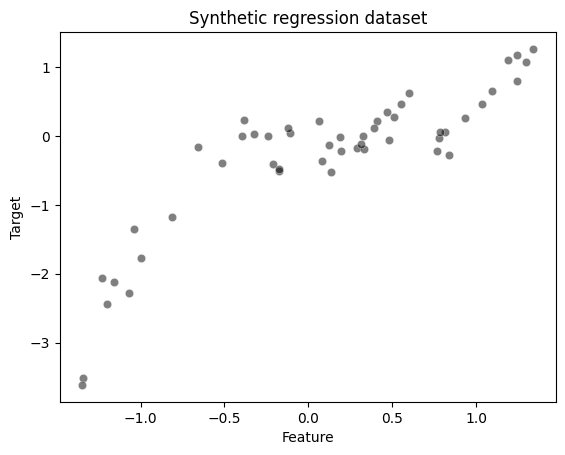

In [11]:
sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)
_ = plt.title("Synthetic regression dataset")

We will start by creating a decision tree regressor. We will set
the depth of the tree so that the resulting learner will underfit the data.


In [12]:
tree = DecisionTreeRegressor(max_depth=3, random_state=0)
tree.fit(data_train, target_train)

target_train_predicted = tree.predict(data_train)
target_test_predicted = tree.predict(data_test)

Using the term "test" here refers to data that was not used for training.
It should not be confused with data coming from a train-test split, as it
was generated in equally-spaced intervals for the visual evaluation of the
predictions.


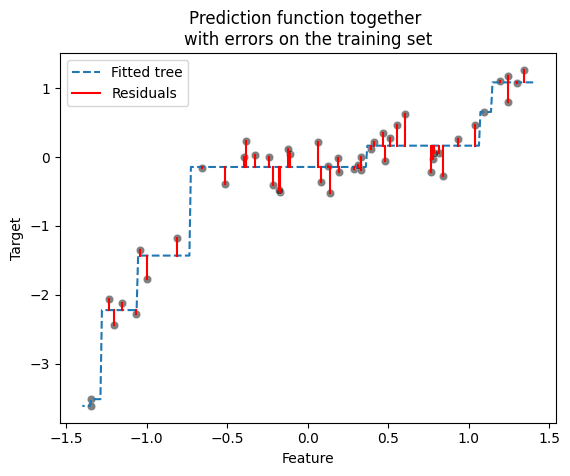

In [13]:
# plot the data
sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)
# plot the predictions
line_predictions = plt.plot(data_test["Feature"], target_test_predicted, "--")

# plot the residuals
for value, true, predicted in zip(data_train["Feature"],
                                  target_train,
                                  target_train_predicted):
    lines_residuals = plt.plot([value, value], [true, predicted], color="red")

plt.legend([line_predictions[0], lines_residuals[0]],
           ["Fitted tree", "Residuals"])
_ = plt.title("Prediction function together \nwith errors on the training set")

Our initial tree was not expressive enough to handle the complexity
of the data.


## Gradient-boosting decision tree (GBDT)

GBDT will fit a decision tree on the residual error (hence the name "gradient") of the previous tree.
Therefore, each new tree in the ensemble predicts the error made by the previous learner instead of predicting the target directly.


In a gradient-boosting algorithm, the idea is to create a second tree that, given the same data `data`, will try
to predict the residuals instead of the vector `target`. We would therefore have a tree that is able to predict the errors made by the initial tree.

Let's train such a tree.


In [14]:
residuals = target_train - target_train_predicted

tree_residuals = DecisionTreeRegressor(max_depth=5, random_state=0)
tree_residuals.fit(data_train, residuals)

target_train_predicted_residuals = tree_residuals.predict(data_train)
target_test_predicted_residuals = tree_residuals.predict(data_test)

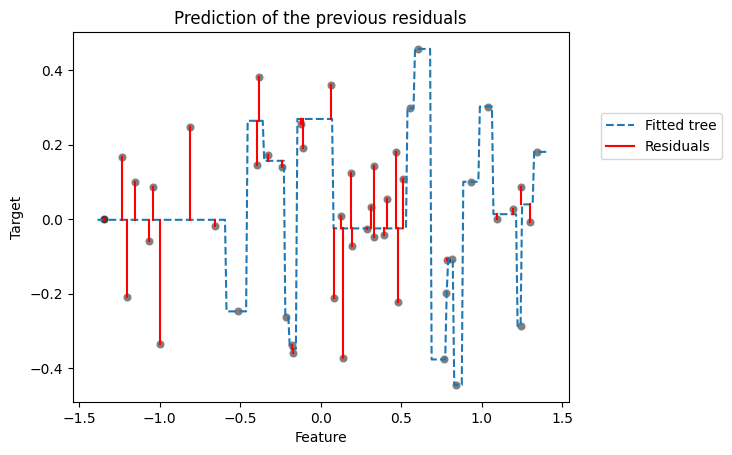

In [15]:
sns.scatterplot(x=data_train["Feature"], y=residuals, color="black", alpha=0.5)
line_predictions = plt.plot(
    data_test["Feature"], target_test_predicted_residuals, "--")

# plot the residuals of the predicted residuals
for value, true, predicted in zip(data_train["Feature"],
                                  residuals,
                                  target_train_predicted_residuals):
    lines_residuals = plt.plot([value, value], [true, predicted], color="red")

plt.legend([line_predictions[0], lines_residuals[0]],
           ["Fitted tree", "Residuals"], bbox_to_anchor=(1.05, 0.8),
           loc="upper left")
_ = plt.title("Prediction of the previous residuals")

We see that this new tree only manages to fit some of the residuals.

- We will focus on a specific sample from the training set (i.e. we know that the sample will be well-predicted using two successive trees).


Let's first select this sample in `data_train`.


In [16]:
sample = data_train.iloc[[-2]]
x_sample = sample['Feature'].iloc[0]
target_true = target_train.iloc[-2]
target_true_residual = residuals.iloc[-2]

Let's plot the previous information and highlight our sample of interest.
Let's start by plotting the original data and the prediction of the first
decision tree.


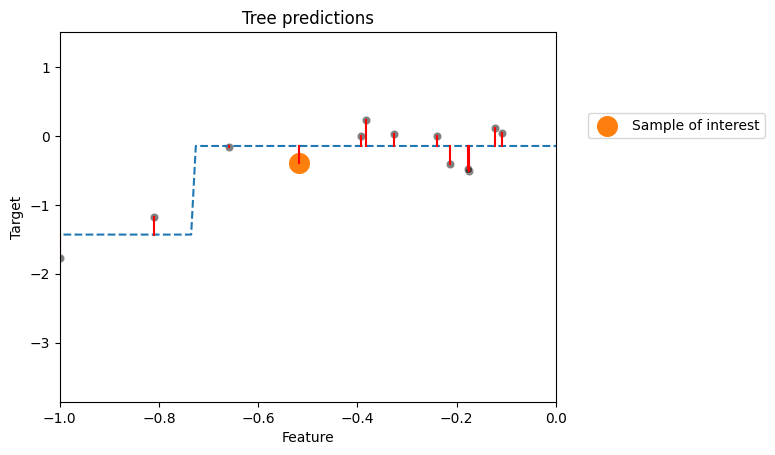

In [17]:
# Plot the previous information:
#   * the dataset
#   * the predictions
#   * the residuals

sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)
plt.plot(data_test["Feature"], target_test_predicted, "--")
for value, true, predicted in zip(data_train["Feature"],
                                  target_train,
                                  target_train_predicted):
    lines_residuals = plt.plot([value, value], [true, predicted], color="red")

# Highlight the sample of interest
plt.scatter(sample, target_true, label="Sample of interest",
            color="tab:orange", s=200)
plt.xlim([-1, 0])
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Tree predictions")

Now, let's plot the residual information. We will plot the residuals
computed from the first decision tree and show the residual predictions.


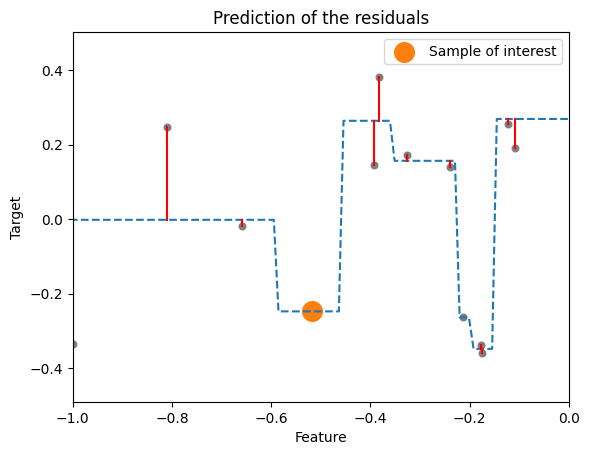

In [18]:
# Plot the previous information:
#   * the residuals committed by the first tree
#   * the residual predictions
#   * the residuals of the residual predictions

sns.scatterplot(x=data_train["Feature"], y=residuals,
                color="black", alpha=0.5)
plt.plot(data_test["Feature"], target_test_predicted_residuals, "--")
for value, true, predicted in zip(data_train["Feature"],
                                  residuals,
                                  target_train_predicted_residuals):
    lines_residuals = plt.plot([value, value], [true, predicted], color="red")

# Highlight the sample of interest
plt.scatter(sample, target_true_residual, label="Sample of interest",
            color="tab:orange", s=200)
plt.xlim([-1, 0])
plt.legend()
_ = plt.title("Prediction of the residuals")

For our sample of interest, our initial tree is making an error (small residual).


When fitting the second tree, the residual in this case is
perfectly fitted and predicted.


In [19]:
print(f"True value to predict for "
      f"f(x={x_sample:.3f}) = {target_true:.3f}")

y_pred_first_tree = tree.predict(sample)[0]
print(f"Prediction of the first decision tree for x={x_sample:.3f}: "
      f"y={y_pred_first_tree:.3f}")
print(f"Error of the tree: {target_true - y_pred_first_tree:.3f}")

True value to predict for f(x=-0.517) = -0.393
Prediction of the first decision tree for x=-0.517: y=-0.145
Error of the tree: -0.248


As we visually observed, we have a small error. Now, we can use the second
tree to try to predict this residual.


In [20]:
print(f"Prediction of the residual for x={x_sample:.3f}: "
      f"{tree_residuals.predict(sample)[0]:.3f}")

Prediction of the residual for x=-0.517: -0.248


We see that our second tree is capable of predicting the exact residual
(error) of our first tree. Therefore, we can predict the value of `x` by
summing the prediction of all the trees in the ensemble.


In [21]:
y_pred_first_and_second_tree = (
    y_pred_first_tree + tree_residuals.predict(sample)[0]
)
print(f"Prediction of the first and second decision trees combined for "
      f"x={x_sample:.3f}: y={y_pred_first_and_second_tree:.3f}")
print(f"Error of the tree: {target_true - y_pred_first_and_second_tree:.3f}")

Prediction of the first and second decision trees combined for x=-0.517: y=-0.393
Error of the tree: 0.000


We chose a sample for which only two trees were enough to make the perfect
prediction.

- One needs to add several trees to the ensemble to successfully correct the error (i.e. the second tree corrects the first tree's error, while the third tree corrects the second tree's error and so on).


### Example: Gradient-Boosted Random Forest Regression

We will compare the generalization performance of random forest and gradient boosting on the California housing dataset.


#### Step 1: Load the Data


In [22]:
data, target = fetch_california_housing(return_X_y=True, as_frame=True)
target *= 100  # rescale the target in k$

#### Step 2: Builds the Model


In [23]:
gradient_boosting = GradientBoostingRegressor(n_estimators=200)
cv_results_gbdt = cross_validate(
    gradient_boosting, data, target, scoring="neg_mean_absolute_error",
    n_jobs=10,
)

#### Step 3: Views the Results


In [24]:
print("Gradient Boosting Decision Tree")
print(f"Mean absolute error via cross-validation: "
      f"{-cv_results_gbdt['test_score'].mean():.3f} ± "
      f"{cv_results_gbdt['test_score'].std():.3f} k$")
print(f"Average fit time: "
      f"{cv_results_gbdt['fit_time'].mean():.3f} seconds")
print(f"Average score time: "
      f"{cv_results_gbdt['score_time'].mean():.3f} seconds")

Gradient Boosting Decision Tree
Mean absolute error via cross-validation: 46.413 ± 2.913 k$
Average fit time: 6.152 seconds
Average score time: 0.006 seconds


#### Step 4: Comparison to Random Forest Regressor


In [25]:
random_forest = RandomForestRegressor(n_estimators=200, n_jobs=-1)
cv_results_rf = cross_validate(
    random_forest, data, target, scoring="neg_mean_absolute_error",
    n_jobs=2,
)

In [26]:
print("Random Forest")
print(f"Mean absolute error via cross-validation: "
      f"{-cv_results_rf['test_score'].mean():.3f} ± "
      f"{cv_results_rf['test_score'].std():.3f} k$")
print(f"Average fit time: "
      f"{cv_results_rf['fit_time'].mean():.3f} seconds")
print(f"Average score time: "
      f"{cv_results_rf['score_time'].mean():.3f} seconds")

Random Forest
Mean absolute error via cross-validation: 46.547 ± 4.337 k$
Average fit time: 8.416 seconds
Average score time: 0.087 seconds


In terms of computation performance, the forest can be parallelized and will
benefit from using multiple cores of the CPU. In terms of scoring
performance, both algorithms lead to very close results.


However, we see that gradient boosting is a very fast algorithm to
predict compared to random forest. This is due to the fact that gradient
boosting uses shallow trees.
